In [2]:
import cv2
import timm
import torch
import models
import argparse
import numpy as np
import matplotlib.pyplot as plt 
import torchvision.transforms as transforms

from PIL import Image
from gradcam.utils import visualize_cam

In [12]:
# 引数の設定

parser = argparse.ArgumentParser()
parser.add_argument('--model', default='vit_tiny_patch16_224', choices=['vit_tiny_patch16_224', 'vit_small_patch16_18x2_224'], type=str, help='model name')
parser.add_argument('--checkpoint', default='./ImageNet/tiny16/best_checkpoint.pth', type=str, help='checkpoint')
# args=[]を追加する。
args = parser.parse_args(args=[])

In [91]:
# Attention Weightを取得するための関数 
def extract(pre_model, target, inputs):
    global blocks
    blocks = None
    def forward_hook(module, inputs, outputs):
        # 順伝搬の出力を features というグローバル変数に記録する 
        global blocks
        blocks = outputs.detach()
        print("blocks:", blocks.shape)
    # コールバック関数を登録する
    handle = target.register_forward_hook(forward_hook) # 推論する
    pre_model.eval()
    pre_model(inputs)
    # コールバック関数を解除する
    handle.remove()
    return blocks

In [96]:
# ViTモデルを読み込む
model = timm.create_model(args.model, pretrained=False)
# 学習済みモデルを読み込む
checkpoint = torch.load(args.checkpoint, map_location='cpu')
model.load_state_dict(checkpoint["model"])
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

# blockごと(Transformer Encoderのlayer)のAttention Weightを取得 # L:層数, H:ヘッド数、N:パッチ数+クラストークン 
attention_weight = []
# 画像をリサイズしてセンタークロップ
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) 
transform = transforms.Compose([transforms.Resize(256), transforms.CenterCrop(224), transforms.ToTensor(), normalize,])
invTrans = transforms.Compose([ transforms.Normalize(mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255], std=[1/0.229, 1/0.224, 1/0.255]),])

# 画像ファイルを読み込み
#image = Image.open('/path/to/image')
image = Image.open('./samples/bird.JPEG')

x = transform(image) # shape :(3, 224, 224)
x = x.view(1, *x.shape) # shape :(1, 3, 224, 224)

for i in range(len(model.blocks)):
    target_module = model.blocks[i].attn.attn_drop
    features = extract(model, target_module, x.to(device)) # shape: (1, H, N, N)
    attention_weight.append([features.to('cpu').detach().numpy().copy()])
attention_weight = np.squeeze(np.concatenate(attention_weight), axis=1) # shape: (L, H, N, N)
print(attention_weight.shape)

# ヘッド方向に平均
mean_head = np.mean(attention_weight, axis=1) # shape: (L, N, N)
print(mean_head.shape)
# NxNの単位行列を加算
mean_head = mean_head + np.eye(mean_head.shape[1])
# 正規化
mean_head = mean_head / mean_head.sum(axis=(1, 2))[:, np.newaxis, np.newaxis] # 層方向に乗算
v = mean_head[-1]
for n in range(1, len(mean_head)):
    v = np.matmul(v, mean_head[-1 - n])
# クラストークンと各パッチトークン間とのAttention Weightから、
# 入力画像サイズまで正規化しながらリサイズしてAttention Mapを生成
mask = v[0, 1:].reshape(14, 14)
attention_map = cv2.resize(mask / mask.max(), (x.shape[2], x.shape[3]))[..., np.newaxis]

# 入力画像を正規化前に戻す
inv_tensor = invTrans(x)[0]
# Attention MapとAttentionをかけた画像を生成
mask = torch.from_numpy(attention_map.astype(np.float32))
_, result = visualize_cam(mask, inv_tensor.to(device))


AttributeError: 'Dropout' object has no attribute 'shape'

NameError: name 'inv_tensor' is not defined

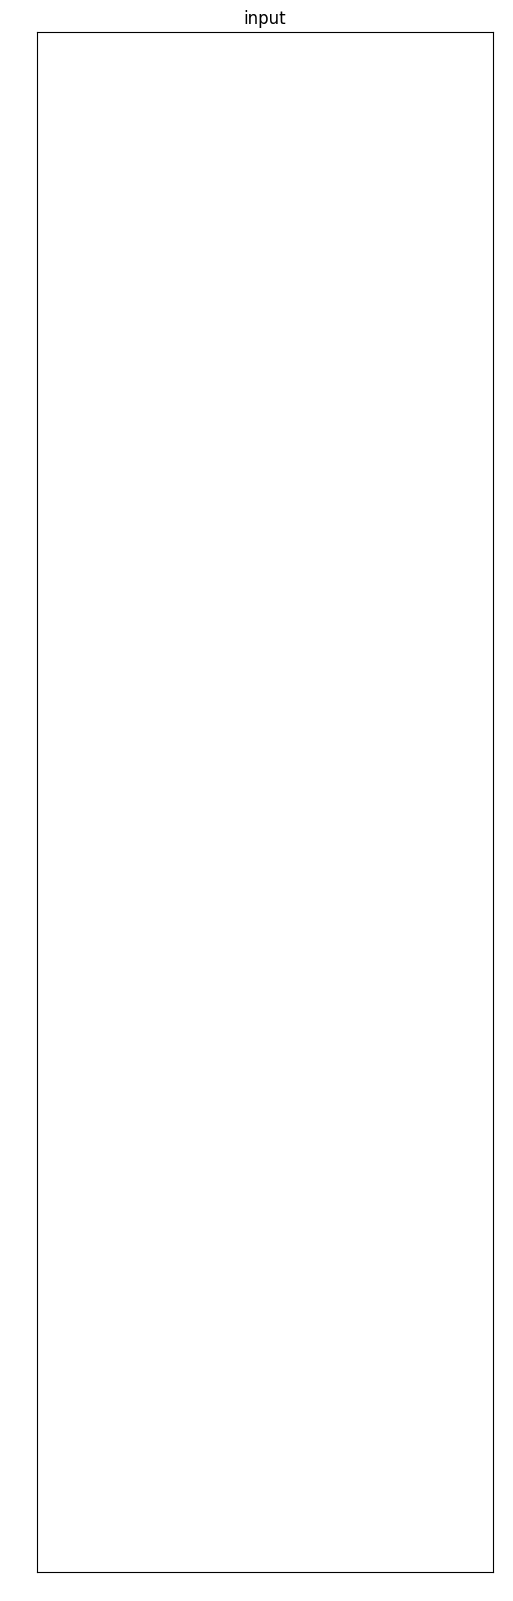

In [109]:
# 入力画像, Attention Map, Attentionをかけた画像を表示 
plt.figure(figsize=[20, 20])
plt.subplot(1, 3, 1)
plt.title('input')
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.imshow(inv_tensor.permute(1,2,0), vmin=0, vmax=1)

plt.subplot(1, 3, 2)
plt.title('attention')
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.imshow(attention_map, cmap='jet')

plt.subplot(1, 3, 3)
plt.title('plot')
plt.xticks(color="None")
plt.yticks(color="None")
plt.tick_params(length=0)
plt.imshow(result.detach().cpu().numpy().transpose(1, 2, 0))
plt.savefig('./attention_rollout.pdf')
plt.clf()
